In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### First, let's load the dataset and check if the dataset has any NULL values

In [17]:
df = pd.read_csv('kidney_disease.csv')
df.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

### We notice that there are several rows with multiple missing values

##### Most missing data: Here, the columns rbc, wc and rc (categorical) have 100+ missing data and sod, pot (numerical) have 80+ missing data 

### Let's use a Correlation matrix to see if we can use direct statistical functions to solve the issue of missing values within numerical columns


Correlation Matrix:
             id       age        bp        sg        al        su       bgr  \
id    1.000000 -0.185308 -0.245744  0.642156 -0.541993 -0.283416 -0.338673   
age  -0.185308  1.000000  0.159480 -0.191096  0.122091  0.220866  0.244992   
bp   -0.245744  0.159480  1.000000 -0.218836  0.160689  0.222576  0.160193   
sg    0.642156 -0.191096 -0.218836  1.000000 -0.469760 -0.296234 -0.374710   
al   -0.541993  0.122091  0.160689 -0.469760  1.000000  0.269305  0.379464   
su   -0.283416  0.220866  0.222576 -0.296234  0.269305  1.000000  0.717827   
bgr  -0.338673  0.244992  0.160193 -0.374710  0.379464  0.717827  1.000000   
bu   -0.307175  0.196985  0.188517 -0.314295  0.453528  0.168583  0.143322   
sc   -0.268683  0.132531  0.146222 -0.361473  0.399198  0.223244  0.114875   
sod   0.364251 -0.100046 -0.116422  0.412190 -0.459896 -0.131776 -0.267848   
pot  -0.092347  0.058377  0.075151 -0.072787  0.129038  0.219450  0.066966   
hemo  0.640298 -0.192928 -0.306540  0.6025

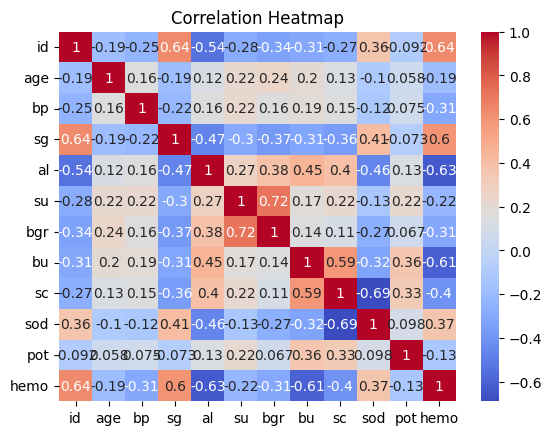

In [18]:
print("\nCorrelation Matrix:\n", df.corr(numeric_only=True))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

### We are using the 'Mean' function to fill in the misisng columns within the numerical columns and 'Mode' function to fill in the missing columns within the categorical columns

In [19]:
for column in df.columns:

    if pd.api.types.is_numeric_dtype(df[column]):
        df[column].fillna(df[column].mean(), inplace=True)
    else:
        df[column].fillna(df[column].mode()[0], inplace=True)

# df.dropna(axis=0, inplace=True)

C:\Users\DYNABOOK\AppData\Local\Temp\ipykernel_21180\2968564890.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)
C:\Users\DYNABOOK\AppData\Local\Temp\ipykernel_21180\2968564890.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


### On checking, we note that all the missing values have succesfully been filled

In [20]:
df.isnull().sum()

id                0
age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

### Let's fix the tab space issue present in many categorical columns 

In [21]:
df['classification'] = df['classification'].str.strip()
print(df['classification'].value_counts())


classification
ckd       250
notckd    150
Name: count, dtype: int64


In [22]:
df['dm'] = df['dm'].str.strip()
df['cad'] = df['cad'].str.strip()
print(df['dm'].value_counts())
print(df['cad'].value_counts())


dm
no     263
yes    137
Name: count, dtype: int64
cad
no     366
yes     34
Name: count, dtype: int64


### In case of tab spaces present in numerical columns, we change that tab space to NaN for computation within those numerical columns

In [23]:
numeric_columns = ['pcv', 'wc', 'rc']
for col in numeric_columns:
    df[col] = df[col].replace(r'\t\?', np.nan, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    non_numeric = df[col].isna().sum()
    print(f"Non-numeric values in {col} converted to NaN: {non_numeric}")

Non-numeric values in pcv converted to NaN: 1
Non-numeric values in wc converted to NaN: 1
Non-numeric values in rc converted to NaN: 1


### Feature Engineering: Categorizing Age and Applying One-Hot Encoding

In [24]:

bins = [0, 30, 60, float("inf")]
labels = ["Young", "Middle-Aged", "Senior"]

df["Age_Category"] = pd.cut(df["age"], bins=bins, labels=labels)

df = pd.get_dummies(df, columns=["Age_Category"], prefix="Age")

df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,classification,Age_Young,Age_Middle-Aged,Age_Senior
0,0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,...,yes,yes,no,good,no,no,ckd,False,True,False
1,1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,...,no,no,no,good,no,no,ckd,True,False,False
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,no,yes,no,poor,no,yes,ckd,False,False,True
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,yes,no,no,poor,yes,yes,ckd,False,True,False
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,no,no,no,good,no,no,ckd,False,True,False


### Feature Engineering II: Applying Label Encoding

In [25]:
label_encoders = {}
for col in ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [26]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,classification,Age_Young,Age_Middle-Aged,Age_Senior
0,0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,...,1,1,0,0,0,0,0,False,True,False
1,1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,...,0,0,0,0,0,0,0,True,False,False
2,2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,...,0,1,0,1,0,1,0,False,False,True
3,3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,...,1,0,0,1,1,1,0,False,True,False
4,4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,...,0,0,0,0,0,0,0,False,True,False


### Then, let's split the dataset into training and testing portions in a 80:20 ratio

In [27]:
X = df.drop(columns=['classification', 'id'])
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Then, we have to standardize the data into arrays before proceeding with the classification

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Here, we are using a Random Forest Classifier for classifying out test data


Model Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        28

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Confusion Matrix:


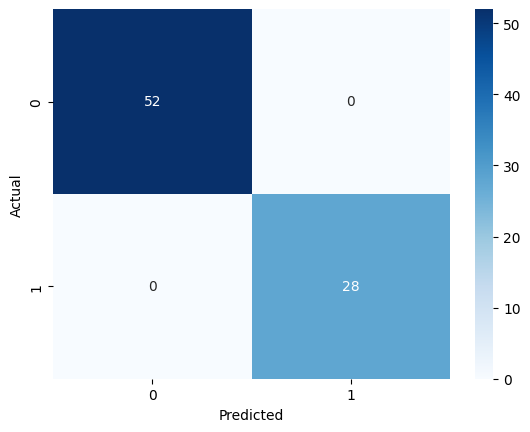

In [29]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### We notice that the model has an accuracy of 100%

#### This is a big indicator of overfitting. In order to furthur understand this issue, the missing values were completely removed and the testing data was classified again.

### However, the Model's accuracy continued to be 100%
#### This could the effect of trying to work with a small dataset of only 400 samples